In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
from tensorflow.keras.models import Model
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal
import seaborn as sns
import matplotlib.pyplot as plt
from astroNN.nn.layers import MCDropout
from scipy.misc import derivative
import scipy.integrate as intg
import scipy as sp


In [2]:
ffnn = tf.keras.models.load_model('../models/FFNN_JLA.h5') 
latent_dim = 1
decoder = tf.keras.models.load_model('../models/vaeffnn_decoder.h5', custom_objects={'latent_dim': latent_dim})
encoder = tf.keras.models.load_model('../models/vaeffnn_encoder.h5')
ffnn_do = tf.keras.models.load_model('../models/FFNN_JLA_DO2.h5', custom_objects={'MCDropout': MCDropout})
#ffnn_do 2 and without 2


In [3]:
syscov = np.loadtxt('../data/cov_jla_binned_distances_31nodes_v1.txt',skiprows=1).reshape((31,31))
file = '../data/jla_binned_distances_31nodes_v1.txt'

# syscov = np.loadtxt('data/jla_v0_covmatrix.dat',skiprows=1).reshape((740,740))
print(np.min(syscov), np.max(syscov), np.mean(syscov))
nsize = len(syscov)


data = np.loadtxt(file, skiprows=3)
z_redshift = data[:, 0]
dist = data[:,1]
errors = np.diag(syscov).reshape(nsize,)
errors_logs = np.where(errors!= 0, np.log(errors), 0)


-0.01084098704 0.02815552265 0.00039265133851975654


In [4]:
scalercov = StandardScaler()
scalercov.fit(syscov)
syscov_sc = scalercov.transform(syscov)

scalerdist = StandardScaler()
scalerdist.fit(data[:,1].reshape(-1,1))
dist_sc = scalerdist.transform(dist.reshape(nsize,1))

scalererr = StandardScaler()
scalererr.fit(errors.reshape(-1,1))
errors_sc = scalererr.transform(errors.reshape(nsize,1))

In [5]:
zpoints = np.linspace(0.01, 1.3, 31)
# zpoints = z_redshift
# zpoints = ranz+0.01*np.random.randn(31)
# orderMag(0.1)
zpoints

array([0.01 , 0.053, 0.096, 0.139, 0.182, 0.225, 0.268, 0.311, 0.354,
       0.397, 0.44 , 0.483, 0.526, 0.569, 0.612, 0.655, 0.698, 0.741,
       0.784, 0.827, 0.87 , 0.913, 0.956, 0.999, 1.042, 1.085, 1.128,
       1.171, 1.214, 1.257, 1.3  ])

In [6]:
ztest2 = encoder.predict(syscov.reshape((-1,31*31)))
z_mean_syscov, z_std_syscov, z_sample_syscov = ztest2
mean_ref = np.mean(dist)
std_ref = np.std(dist)
delta_mean = z_sample_syscov - mean_ref


In [7]:
pred_random = ffnn.predict(np.log10(zpoints))
dlfake = scalerdist.inverse_transform(pred_random.reshape(-1,1))
index = np.argsort(zpoints)
fake_data = np.stack((zpoints[index], dlfake.reshape(31,)[index]), axis=1)

# np.savetxt("fake_binned_JLA_inter_0.dat",  fake_data, delimiter= " ", header="#fake data\n# z\n# mu", fmt='%1.9f')

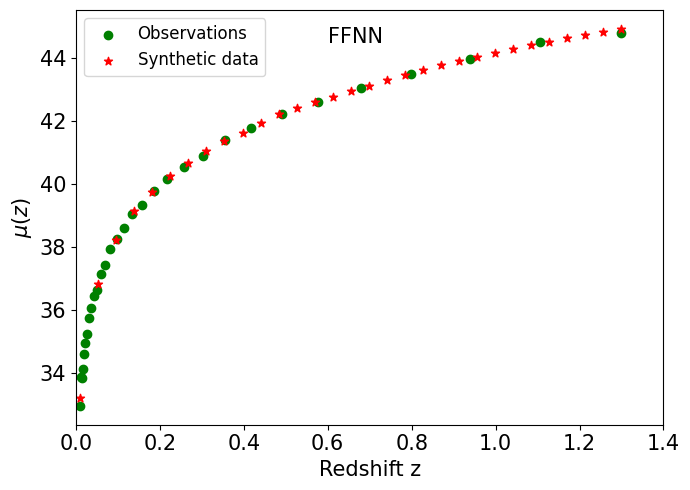

In [8]:
plt.figure(figsize=(7, 5), dpi=100)
plt.scatter(z_redshift, dist,c='g', label='Observations')
plt.scatter(zpoints, dlfake, c='r', label='Synthetic data', marker='*')


plt.xlabel("Redshift z", fontsize=15)
plt.ylabel("$\mu(z)$", fontsize=15)
plt.xlim(-0.0, np.max(z_redshift)+0.1)
plt.xticks(fontsize=15)
plt.text(0.6, 44.5, 'FFNN', fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.legend(fontsize=12)
# plt.savefig('JLA_FFNN.png')

In [9]:
mean_pred_interpoint = np.mean(dlfake)
std_pred_interpoint = np.std(dlfake)

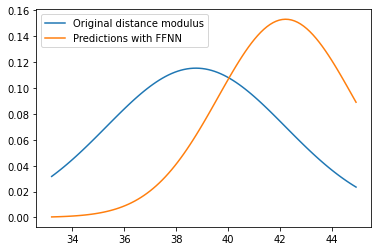

In [10]:
xmin = np.min(dlfake)
xmax= np.max(dlfake)
x = np.linspace(xmin, xmax, 100)
y1 = sp.stats.norm.pdf(x, mean_ref, std_ref)
y2 = sp.stats.norm.pdf(x, mean_pred_interpoint, std_pred_interpoint)

plt.plot(x, y1, label='Original distance modulus')
plt.plot(x, y2, label='Predictions with FFNN')

# plt.show()
# dist_sc
plt.legend()

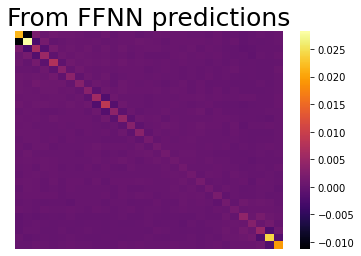

In [11]:
z_sample = np.array([mean_pred_interpoint+delta_mean])

newmatrix = decoder.predict(z_sample)
# newmatrixr = scalercov.inverse_transform(newmatrix.reshape(31,31))
newmatrixr = newmatrix.reshape(31,31)
# newmatrixr = newmatrixr@D@newmatrixr.T
# # clean_imgr = clean_img[0,:,:,0].reshape(31,31)

# plt.figure(figsize=(9, 7), dpi=100)
# sns.set(font_scale=2)

sns.heatmap(pd.DataFrame(newmatrixr), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False, cbar=True)

# np.savetxt("fake_binned_JLA_COVAE_0.dat", newmatrixr, delimiter= " ", header="#fake COV")
plt.title('From FFNN predictions',fontsize=25)
plt.savefig('vae_cov_ffnn.png')

# Now with MC-DO

In [12]:
pred_random = ffnn_do.predict(np.log10(zpoints))
dlfake_do = scalerdist.inverse_transform(pred_random[:,0].reshape(-1,1))
index = np.argsort(zpoints)
fake_data = np.stack((zpoints[index], dlfake_do.reshape(31,)[index]), axis=1)

# np.savetxt("fake_binned_JLADO_inter_0.dat",  fake_data, delimiter= " ", header="#fake data\n# z\n# mu", fmt='%1.9f')

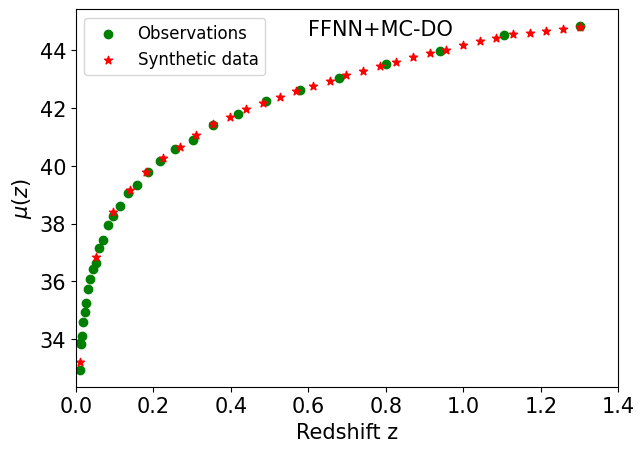

In [13]:
plt.figure(figsize=(7, 5), dpi=100)
plt.scatter(z_redshift, dist,c='g', label='Observations')
plt.scatter(zpoints, dlfake_do, c='r', label='Synthetic data', marker='*')


plt.xlabel("Redshift z", fontsize=15)
plt.ylabel("$\mu(z)$", fontsize=15)
plt.xlim(-0.0, np.max(z_redshift)+0.1)
plt.xticks(fontsize=15)
plt.text(0.6, 44.5, 'FFNN+MC-DO', fontsize=15)
plt.yticks(fontsize=15)
# plt.tight_layout()
plt.legend(fontsize=12)

In [14]:
mean_pred_interpoint_DO = np.mean(dlfake_do)
std_pred_interpoint_DO = np.std(dlfake_do)

Text(0.5, 0, 'Modulus distance $\\mu (z)$')

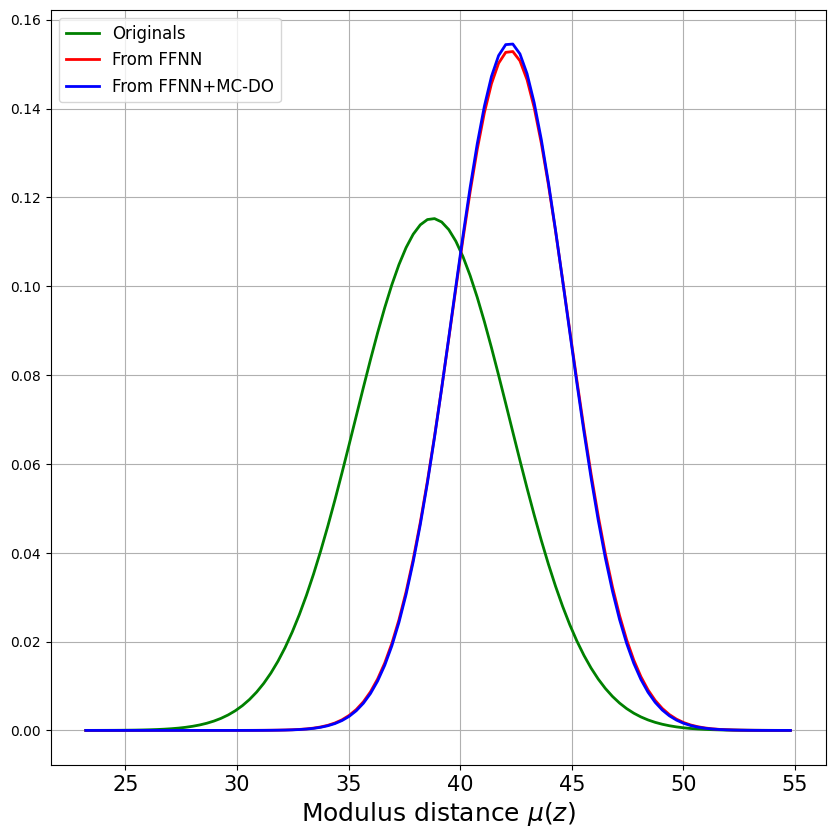

In [15]:
plt.figure(figsize=(10, 10), dpi=100, facecolor='white')
# plt.grid(b=None)

xmin = np.min(dlfake_do)
xmax= np.max(dlfake_do)
x = np.linspace(xmin-10, xmax+10, 100)
y1 = sp.stats.norm.pdf(x, mean_ref, std_ref)
y2 = sp.stats.norm.pdf(x, mean_pred_interpoint, std_pred_interpoint)
y3 = sp.stats.norm.pdf(x, mean_pred_interpoint_DO, std_pred_interpoint_DO)


plt.plot(x, y1, label='Originals', color='g', linewidth=2)
plt.plot(x, y2, label='From FFNN', color='r', linewidth=2)
plt.plot(x, y3, label='From FFNN+MC-DO', color='b', linewidth=2)

plt.grid(True)

# plt.hist(dist, density=True, alpha=0.3, color='g')
# plt.hist(dlfake, density=True, alpha=0.3, color='r')
# plt.hist(dlfake_do, density=True, alpha=0.3, color='b')
# plt.show()
# dist_sc
plt.legend(fontsize=12, loc='upper left')
# plt.yticks([])
plt.xticks(fontsize=15)

plt.xlabel("Modulus distance $\mu (z)$", fontsize=18)
# plt.savefig('modulus_dist_gauss.png', transparent=True)

No handles with labels found to put in legend.


(array([32., 34., 36., 38., 40., 42., 44., 46.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

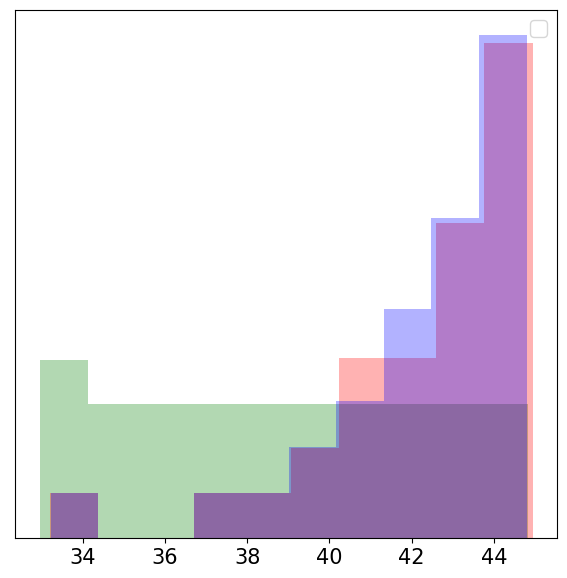

In [16]:
plt.figure(figsize=(7, 7), dpi=100)

plt.hist(dist, density=True, alpha=0.3, color='g')
plt.hist(dlfake, density=True, alpha=0.3, color='r')
plt.hist(dlfake_do, density=True, alpha=0.3, color='b')
# dist_sc
plt.legend(fontsize=15)
plt.yticks([])
plt.xticks(fontsize=15)

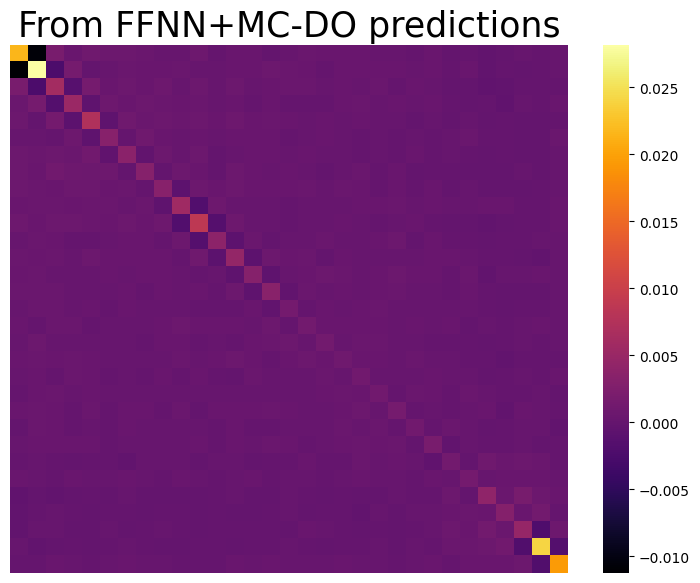

In [17]:
z_sample = np.array([mean_pred_interpoint_DO+delta_mean])

newmatrix = decoder.predict(z_sample)
# newmatrixr = scalercov.inverse_transform(newmatrix.reshape(31,31))
newmatrixr = newmatrix.reshape(31,31)
# newmatrixr = newmatrixr@D@newmatrixr.T
# # clean_imgr = clean_img[0,:,:,0].reshape(31,31)


plt.figure(figsize=(9, 7), dpi=100)
# sns.set(font_scale=2)
sns.heatmap(pd.DataFrame(newmatrixr), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False, cbar=True)

# np.savetxt("fake_binned_JLA_COVAE_DO_0.dat", newmatrixr, delimiter= " ", header="#fake COV")
plt.title('From FFNN+MC-DO predictions', fontsize=25)
plt.savefig('vae_cov_ffnn_do.png')

(array([ 1.,  0.,  0.,  1.,  1.,  2.,  3.,  5.,  7., 11.]),
 array([33.228195, 34.384888, 35.54158 , 36.698273, 37.854965, 39.011658,
        40.16835 , 41.325043, 42.481735, 43.638428, 44.79512 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

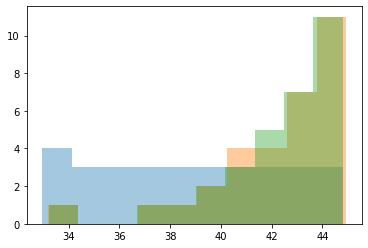

In [18]:
# sns.histplot(np.array([dist.reshape(31,), dlfake.reshape(31,), dlfake_do.reshape(31,)]))
plt.hist(dist, alpha=0.4)
plt.hist(dlfake, alpha=0.4)
plt.hist(dlfake_do, alpha=0.4)
# plt.yscale('log')

/home/cosmocicatais/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/cosmocicatais/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/cosmocicatais/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with si

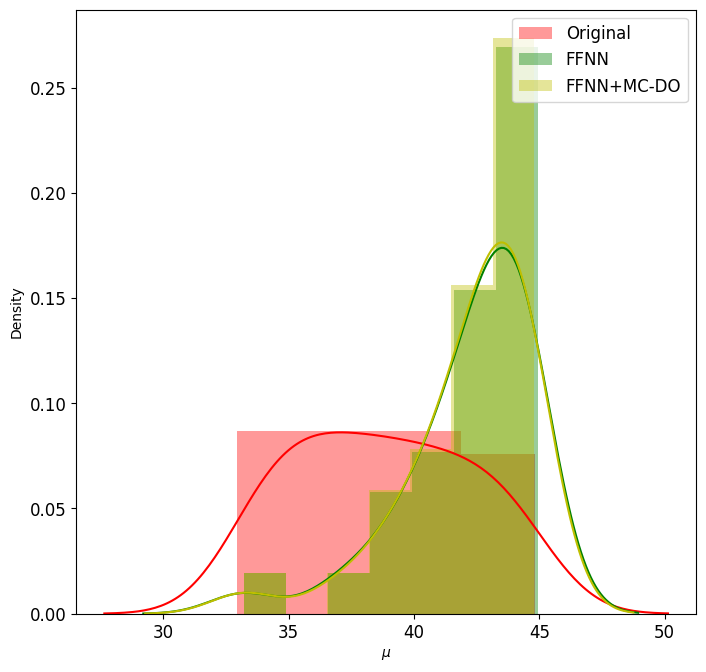

In [19]:
plt.figure(figsize=(8, 8), dpi=100)

sns.distplot(dist, color='r', label='Original')
sns.distplot(dlfake, color='g', label='FFNN')
sns.distplot(dlfake_do, color='y', label='FFNN+MC-DO')
plt.xlabel('$\mu$')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(loc='upper right', fontsize=12)